In [197]:
import time
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from matplotlib import pyplot
np.random.seed(2017) # set random seed value to get reproducible results

In [198]:
# store start time to get execution time of entire script
start_time = time.time()

In [199]:
df = pd.read_csv('data_cleaned.csv', index_col=[0])
print(df.shape)
df.head()

(5458, 39)


,engage30,init,female_cd,nonwhite_cd,unemplmt_cd,primsev_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,gvsg_cd,tsd_0_cd,und15_cd,CWSg_0_cd,srprobg_cd,S9y10_cd,dldiag_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,suicprbs_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,homeless_0_cd,S6_cd,gcsg_0_cd,ncar_cd,ada_0_cd,Raceg4_cd_1,Raceg4_cd_2,Raceg4_cd_3,Raceg4_cd_4,loc_cd_1,loc_cd_2,loc_cd_3,loc_cd_6,loc_cd_9
0,1,1,0,0,1,2,1,0,1,0,2,1,1,0,1,2,1,2,1,2,1,0,1,1,1,0,0,0,0,90,1,0,0,0,1,0,0,0,0
4,1,1,0,0,0,2,0,1,1,0,0,0,1,0,0,8,0,1,0,0,1,0,1,2,1,1,0,1,1,74,1,0,0,0,1,0,0,0,0
9,0,1,0,0,0,2,0,0,2,0,0,0,1,0,0,8,0,0,1,0,0,0,0,1,1,0,0,0,1,90,1,0,0,0,1,0,0,0,0
11,1,1,0,0,0,2,0,1,1,0,2,0,1,0,1,1,1,1,2,2,1,0,2,1,1,0,0,0,0,90,1,0,0,0,1,0,0,0,0
16,1,1,0,0,0,2,0,0,1,0,2,1,1,0,1,1,1,2,1,2,2,0,2,2,2,1,1,2,1,0,1,0,0,0,1,0,0,0,0


In [200]:
opioids_mask = df['primsev_cd'] == 5
opioids = df[opioids_mask]
opioids = opioids.drop(columns=['primsev_cd'])

amphetamines_mask = df['primsev_cd'] == 2
cocaine_mask = df['primsev_cd'] == 4
stimulants = df[amphetamines_mask | cocaine_mask]
stimulants = stimulants.drop(columns=['primsev_cd'])

print('Opioids:', opioids.shape)
print('Stimulants:', stimulants.shape)

Opioids: (933, 38)
Stimulants: (4525, 38)


In [201]:
stimulants['init'].value_counts()

1    4021
0     504
Name: init, dtype: int64

In [202]:
opioids['init'].value_counts()

1    830
0    103
Name: init, dtype: int64

In [203]:
stimulants['engage30'].value_counts()

1    2861
0    1664
Name: engage30, dtype: int64

In [204]:
opioids['engage30'].value_counts()

1    657
0    276
Name: engage30, dtype: int64

In [205]:
def run_model(model, data, grouping, outcome):
    X = data.drop(columns=[outcome])
    y = data[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)    
    
    res = cross_validate(model, X_train, y_train, return_estimator=True, cv=5)
    top_model_ind = list(res['test_score']).index(max(list(res['test_score'])))
    model = res['estimator'][top_model_ind]
    
    y_pred = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    # https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    
    try:
        # random forest
        feature_importance = model.feature_importances_ 
        label = "RF " + grouping + " " + outcome
    except AttributeError:
        # logistic regression
        feature_importance = model.coef_[0]
        label = "LR " + grouping + " " + outcome
    
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('AUC: %.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title(label)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    features = X.columns
    feature_importance_df = pd.DataFrame({"feature": features, label: feature_importance})
    feature_importance_df = feature_importance_df.set_index('feature')
    return feature_importance_df

In [206]:
opioids_engage30 = opioids.drop(columns=['init'])
opioids_init = opioids.drop(columns=['engage30'])
stimulants_engage30 = stimulants.drop(columns=['init'])
stimulants_init = stimulants.drop(columns=['engage30'])

In [207]:
features = list(opioids_engage30.columns)
features.remove('engage30')
feature_importance = pd.DataFrame({"feature": features})

feature_importance_random_forest = feature_importance.set_index('feature')
feature_importance_logistic_regression = feature_importance.set_index('feature')

X_train: (3031, 36) X_test: (1494, 36) y_train: (3031,) y_test: (1494,)
Accuracy: 0.8942436412315931
F1: 0.9441301272984443
Precision: 0.8983849259757739
Recall: 0.9947839046199702
AUC: 0.698


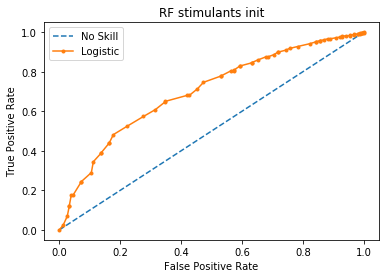

In [208]:
random_forest_stimulants_init = run_model(RandomForestClassifier(), stimulants_init, 'stimulants', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_init)

X_train: (3031, 36) X_test: (1494, 36) y_train: (3031,) y_test: (1494,)
Accuracy: 0.8768406961178046
F1: 0.9343794579172612
Precision: 0.8774279973208305
Recall: 0.9992372234935164
AUC: 0.652


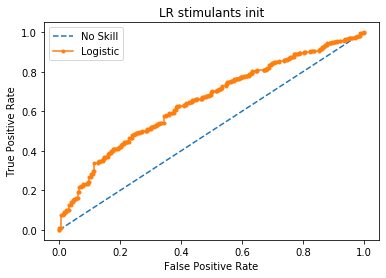

In [209]:
logistic_regression_stimulants_init = run_model(LogisticRegression(max_iter=1000), stimulants_init, 'stimulants', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_init)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.8928571428571429
F1: 0.9433962264150945
Precision: 0.8928571428571429
Recall: 1.0
AUC: 0.610


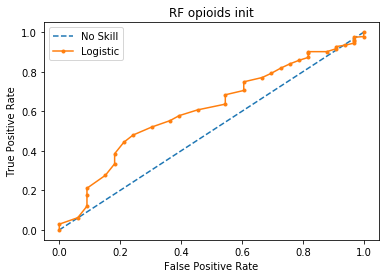

In [210]:
random_forest_opioids_init = run_model(RandomForestClassifier(), opioids_init, 'opioids', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_init)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.9090909090909091
F1: 0.9522184300341298
Precision: 0.9147540983606557
Recall: 0.9928825622775801
AUC: 0.720


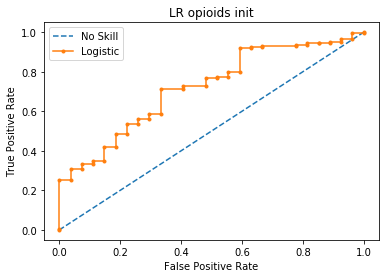

In [211]:
logistic_regression_opioids_init = run_model(LogisticRegression(max_iter=1000), opioids_init, 'opioids', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_init)

X_train: (3031, 36) X_test: (1494, 36) y_train: (3031,) y_test: (1494,)
Accuracy: 0.6412315930388219
F1: 0.7541284403669725
Precision: 0.6699266503667481
Recall: 0.8625393494228751
AUC: 0.621


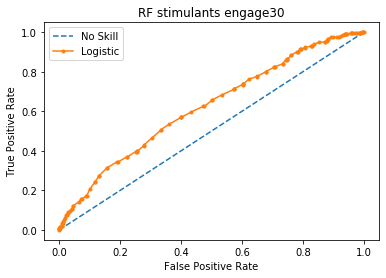

In [212]:
random_forest_stimulants_engage30 = run_model(RandomForestClassifier(), stimulants_engage30, 'stimulants', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_engage30)

X_train: (3031, 36) X_test: (1494, 36) y_train: (3031,) y_test: (1494,)
Accuracy: 0.6291834002677377
F1: 0.7546501328609388
Precision: 0.6464339908952959
Recall: 0.9063829787234042
AUC: 0.593


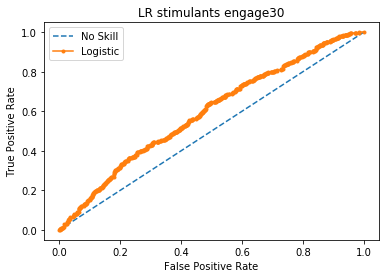

In [213]:
logistic_regression_stimulants_engage30 = run_model(LogisticRegression(max_iter=1000), stimulants_engage30, 'stimulants', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_engage30)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.6883116883116883
F1: 0.8032786885245901
Precision: 0.7205882352941176
Recall: 0.9074074074074074
AUC: 0.575


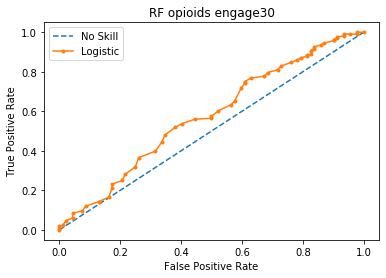

In [214]:
random_forest_opioids_engage30 = run_model(RandomForestClassifier(), opioids_engage30, 'opioids', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_engage30)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.7142857142857143
F1: 0.8225806451612904
Precision: 0.7338129496402878
Recall: 0.9357798165137615
AUC: 0.607


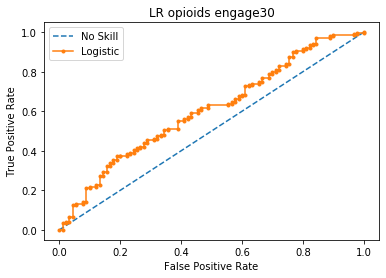

In [215]:
logistic_regression_opioids_engage30 = run_model(LogisticRegression(max_iter=1000), opioids_engage30, 'opioids', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_engage30)

In [216]:
def func(row, groups):
    result = 0
    for group in groups:
        result += abs(row[group])
    return result

feature_importance_random_forest['abs sum'] = feature_importance_random_forest.apply(lambda row: func(row, feature_importance_random_forest.columns), axis=1)
feature_importance_random_forest = feature_importance_random_forest.sort_values(by='abs sum', ascending=False)

feature_importance_logistic_regression['abs sum'] = feature_importance_logistic_regression.apply(lambda row: func(row, feature_importance_logistic_regression.columns), axis=1)
feature_importance_logistic_regression = feature_importance_logistic_regression.sort_values(by='abs sum', ascending=False)

In [217]:
feature_importance_random_forest.head() 

,RF stimulants init,RF opioids init,RF stimulants engage30,RF opioids engage30,abs sum
feature,,,,,
ada_0_cd,0.104832,0.113719,0.100904,0.108122,0.427578
cjsig_0_cd,0.046983,0.047720,0.041553,0.043951,0.180207
SESg_0_cd,0.037166,0.037009,0.036350,0.051537,0.162063
gcsg_0_cd,0.041984,0.040499,0.039989,0.038101,0.160573
gvsg_cd,0.043595,0.038818,0.040775,0.033955,0.157143


In [218]:
feature_importance_logistic_regression.head() 

,LR stimulants init,LR opioids init,LR stimulants engage30,LR opioids engage30,abs sum
feature,,,,,
loc_cd_9,-0.745703,-1.263854,0.723292,0.810521,3.543370
loc_cd_1,1.133532,1.039043,0.253642,-0.504388,2.930605
und15_cd,-0.307082,-1.010056,0.027313,-0.570591,1.915042
loc_cd_6,-0.144439,0.089457,-0.646724,-0.958544,1.839164
dldiag_cd,-0.050322,1.115691,0.213279,0.447831,1.827122


In [219]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('feature_importance.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
feature_importance_random_forest.to_excel(writer, sheet_name='Random Forest')
feature_importance_logistic_regression.to_excel(writer, sheet_name='Logistic Regression')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [220]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 0 minutes 11 seconds ---


In [221]:
# notes

# distribution of engage30 is better (~60% positive rate) than init (~90% positive rate)
# based on the low coefficients for all the features for init predictions it looks like the 
#   model is always predicting the same thing
# engage30 dominates feature importance